In [1]:
from argovisHelpers import helpers as avh
import datetime, pandas, matplotlib
import helpers

API_ROOT='https://argovis-api.colorado.edu/'
API_KEY=''

## small region with oxygen at a given qc? Show time evolution for a subset of pressures

In [2]:
natlantic = [[-51.67968750000001,56.029498073208586],[-41.83593750000001,56.42038489717793],[-32.34375000000001,56.80729573996785],[-19.687500000000004,56.22543989970805],[-15.468750000000002,41.319627582090206],[-27.773437500000004,40.78941637031731],[-42.890625,41.58312932313233],[-52.3828125,41.319627582090206],[-51.67968750000001,56.029498073208586]]
datafilter = {
    'polygon': natlantic,
    'startDate': '2020-01-01T00:00:00Z',
    'endDate': '2021-01-01T00:00:00Z',
    'data': 'doxy,1',
    'presRange': [0,1000]
}

floats = avh.query('argo', options=datafilter, apikey=API_KEY, apiroot=API_ROOT)

In [3]:
float_longitudes = [x['geolocation']['coordinates'][0] for x in floats]
float_latitudes  = [x['geolocation']['coordinates'][1] for x in floats]
float_id = [x['_id'].split('_')[0] for x in floats]

## choose markers on map categorically by float ID
id_markermap = helpers.marker_map(set(float_id))
id_markers = [id_markermap[x] for x in float_id]

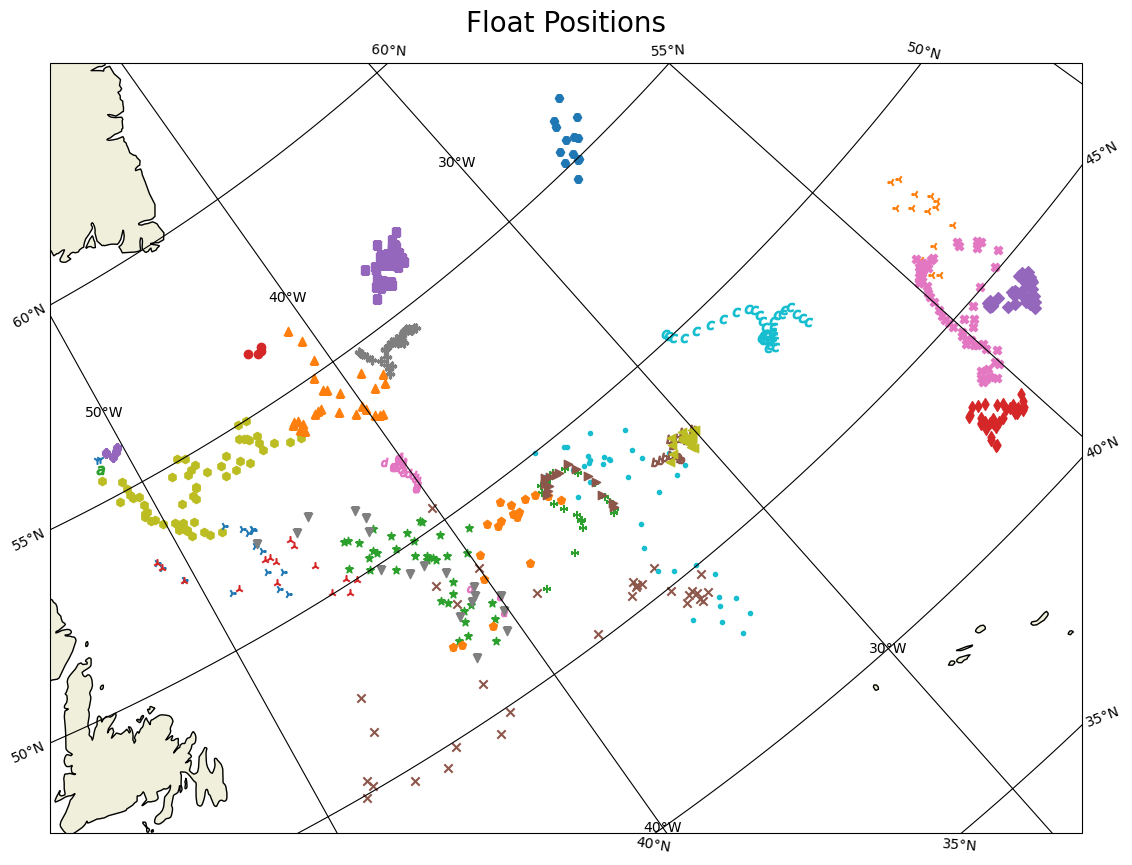

In [4]:
helpers.simple_map(float_longitudes,float_latitudes,markers=id_markers, title='Float Positions')

In [5]:
df = helpers.level_df(floats, ['pressure', 'doxy', 'months'])

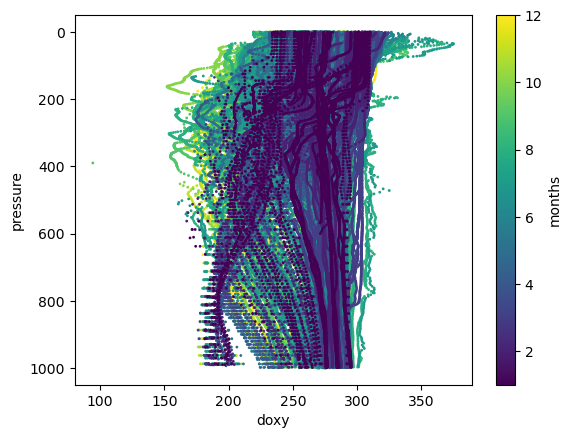

In [6]:
plot = df.plot(kind='scatter', x='doxy', y='pressure', c='months', colormap='viridis', s=1);
plot.invert_yaxis()

## global map of all oxygen profiles
 - could add a thin pressure filter to this to satisfy the request "Map with oxygen measurements for a month and within a thin pressure layer" - but do we need both, the difference seems trivial?

In [7]:
datafilter = {
    'startDate': '2020-01-01T00:00:00Z',
    'endDate': '2021-01-01T00:00:00Z',
    'data': 'doxy',
    'compression': 'minimal'
}

doxy = avh.query('argo', options=datafilter, apikey=API_KEY, apiroot=API_ROOT)

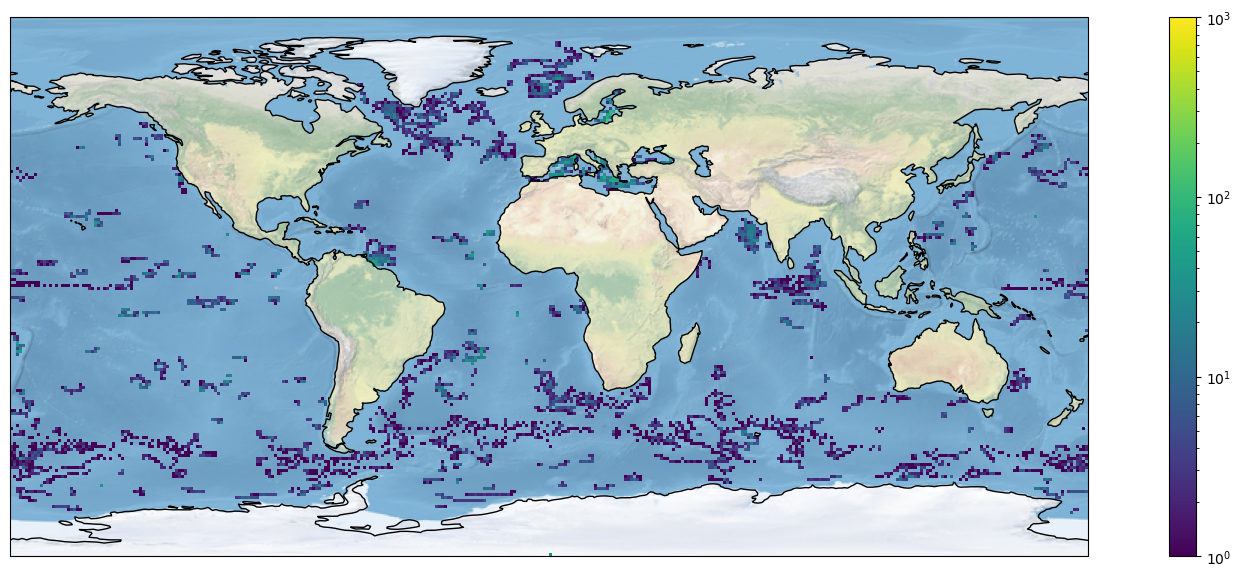

In [8]:
df = helpers.mapping_df(doxy)
helpers.map_count_in_bins(df,datafilter['startDate'],datafilter['endDate'])

## Timeseries for the number of oxygen profiles globally

<AxesSubplot:xlabel='timestamps,timestamps'>

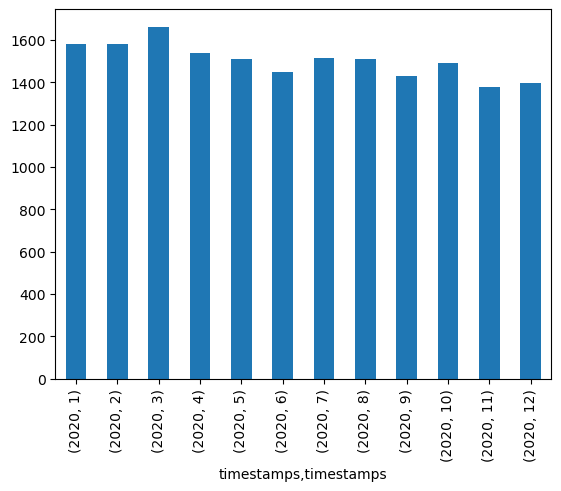

In [12]:
df['timestamps'].groupby([df["timestamps"].dt.year, df["timestamps"].dt.month]).count().plot(kind="bar")

In [14]:
# hacks below this line

params = {
  "startDate": '2012-01-01T00:00:00Z',
  "endDate": '2012-04-01T00:00:00Z',
  "polygon": [[-49.92187499999999,56.17002298293205],[-48.1640625,49.61070993807422],[-56.6015625,42.5530802889558],[-72.421875,35.746512259918504],[-72.421875,27.059125784374068],[-47.4609375,26.115985925333536],[-19.6875,27.371767300523047],[-12.65625,36.59788913307022],[-11.6015625,46.558860303117164],[-13.0078125,56.75272287205736],[-49.92187499999999,56.17002298293205]],
  "data": 'rg09_temperature'
}

rgdata = avh.query('grids/rg09', options=params, apikey=API_KEY, apiroot=API_ROOT)

In [10]:
metadata_params = {
    "id": rgdata[0]['metadata'][0]
}

rgmeta = avh.query('grids/meta', options=metadata_params, apikey=API_KEY, apiroot=API_ROOT)

In [24]:
df = helpers.level_df(rgdata, ['rg09_temperature', 'longitude', 'latitude', 'timestamp'], per_level_pressures=rgmeta[0]['levels'])

In [25]:
df = df.set_index(["latitude","longitude","timestamp","pressure"])
ds = df.to_xarray()

In [26]:
print('latitudes:',ds['latitude'].data)
print('longitudes:',ds['longitude'].data)
print('times:',ds['timestamp'].data)
print('pressures:',ds['pressure'].data)

latitudes: [26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5
 40.5 41.5 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5
 54.5 55.5 56.5 57.5]
longitudes: [-71.5 -70.5 -69.5 -68.5 -67.5 -66.5 -65.5 -64.5 -63.5 -62.5 -61.5 -60.5
 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 -51.5 -50.5 -49.5 -48.5
 -47.5 -46.5 -45.5 -44.5 -43.5 -42.5 -41.5 -40.5 -39.5 -38.5 -37.5 -36.5
 -35.5 -34.5 -33.5 -32.5 -31.5 -30.5 -29.5 -28.5 -27.5 -26.5 -25.5 -24.5
 -23.5 -22.5 -21.5 -20.5 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5]
times: ['2012-01-15T00:00:00.000000000' '2012-02-15T00:00:00.000000000'
 '2012-03-15T00:00:00.000000000']
pressures: [   2.5   10.    20.    30.    40.    50.    60.    70.    80.    90.
  100.   110.   120.   130.   140.   150.   160.   170.   182.5  200.
  220.   240.   260.   280.   300.   320.   340.   360.   380.   400.
  420.   440.   462.5  500.   550.   600.   650.   700.   750.   800.
  850.   900.   950.  1000.  1050.  1100.  1150.  

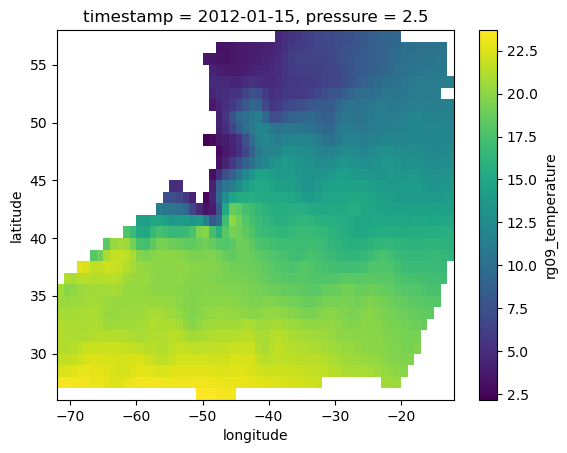

In [28]:
gridmap = ds.loc[{"timestamp":avh.parsetime('2012-01-15T00:00:00.000Z'), "pressure":2.5}]
gridmap['rg09_temperature'].plot()